<H3><span style="color:teal">RETAIL IMAGE CLASSIFICATION DEMO</span></H3>

We'll use the retail product images - let's call this **generic RPIs** and build a convolutional neural net **(CNN)** based on training from a pre-trained network.

In [1]:
# Import the required libraries
from dlpy.applications import *  # Get all the prebuilt models out of the box
import os,_config,swat,graphviz
from dlpy.splitting import two_way_split
from dlpy.images import ImageTable

Connect to the CAS Server - <span style="color:teal">**Simple & Easy!**</span>

In [2]:
user,pswd = _config.login()
host=''
portnum=5570 #CAS Binary Port
conn = swat.CAS(host,portnum,user,pswd)

In [3]:
# Change the caslib to the one we would want to use
conn.setsessopt(caslib='casuser')

NOTE: 'CASUSER(viyademo01)' is now the active caslib.


+ Elapsed: 0.0612s, user: 0.00586s, sys: 0.00545s, mem: 0.787mb

In [4]:
# Inspect a path using file info CAS action
conn.fileinfo('retail_images')

,Permission,Owner,Group,Name,Size,Encryption,Time
0,drwxr-xr-x,viyademo01,marketing,shirt,8192,,05May2018:19:10:17
1,drwxr-xr-x,viyademo01,marketing,dress,8192,,05May2018:19:10:17
2,drwxr-xr-x,viyademo01,marketing,handbag,8192,,05May2018:19:10:17
3,drwxr-xr-x,viyademo01,marketing,trouser,8192,,05May2018:19:10:17
4,drwxr-xr-x,viyademo01,marketing,sunglasses,8192,,05May2018:19:10:17


In [5]:
img_path='/home/viyademo01/casuser/retail_images' #point to the image files in the server
retail_images = ImageTable.load_files(conn, path=img_path)  # load the files 

In [6]:
retail_images.shuffle(casout=dict(name=retail_images, replace=True))
# Now to check out this IMAGE TABLE 
retail_images.head()

,_image_,_label_,_filename_0
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,shirt,00000136.jpg
1,"b'\xff\xd8\xff\xe1\x16""Exif\x00\x00II*\x00\x08...",handbag,00000002.jpg
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,sunglasses,00000121.jpg
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,trouser,00000147.jpg
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,trouser,00000053.jpg


In [7]:
# And the column info with the columninfo action
retail_images.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,varbinary,7160444,7160444,0,0
1,_label_,2,varchar,10,10,0,0
2,_filename_0,3,varchar,73,73,0,0


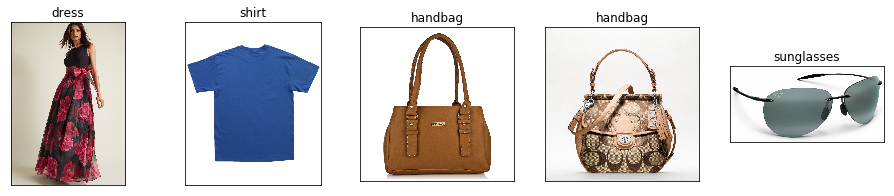

In [10]:
# Here's how we can easily check out the images
retail_images.show(nimages=5,randomize=True)

In [11]:
# And some basic frequency info
retail_images.label_freq

,Level,Frequency
dress,1,243
handbag,2,246
shirt,3,235
sunglasses,4,244
trouser,5,239


Next logical step is for us to get some **summary stats on the images**

In [12]:
# Like so
retail_images.image_summary

jpg                  1207
minWidth              455
maxWidth             4000
minHeight             547
maxHeight            5200
meanWidth         1198.35
meanHeight        1352.59
mean1stChannel    192.335
min1stChannel           0
max1stChannel         255
mean2ndChannel    194.321
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    201.139
min3rdChannel           0
max3rdChannel         255
dtype: object

So, we have images in all *shapes* and **sizes**. We're going to have to reshape. How do we do it?

In [13]:
# Like so
retail_images.resize(width=224,height=224,inplace=True)

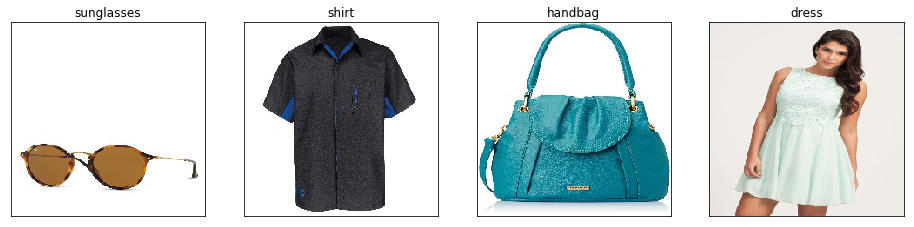

In [20]:
# Now lets take a look at them again !!
retail_images.show(nimages=4,randomize=True)

In [21]:
tr_ret_img, te_ret_img = two_way_split(retail_images, test_rate=20, seed=123)

In [22]:
tr_ret_img.label_freq

,Level,Frequency
dress,1,194
handbag,2,197
shirt,3,188
sunglasses,4,195
trouser,5,191


### Start building models based on Pre-Built Models

#### Define/Specify the model

The following are the key aspects to recognize here :-
* Pre-defined models - They are your friends. Saves Time. Uses a tested architecture. 
* Pre-trained weights - Embrace them whereever possible. Blaze your own trail by building on it or define your own network if you have a good reason to go down that route

In [23]:
pre_trained_weights_path = '/home/viyademo01/casuser/pre_trained_models'

In [24]:
model_vgg16 = VGG16(
    conn, model_table='VGG16_notop',
    n_classes=5, n_channels=3, width=224, height=224, scale=1,
    offsets=(103.939, 116.779, 123.68), 
    pre_train_weight=True, 
    pre_train_weight_file=os.path.join(pre_trained_weights_path, 'vgg16/VGG_ILSVRC_16_layers.caffemodel.h5'),
    include_top=False)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16_notop" according to the model name in the table.


In [25]:
tr_ret_img.as_patches(width=200, height=200, step_size=24, output_width=224, output_height=224)

In [26]:
tr_ret_img.label_freq

,Level,Frequency
dress,1,776
handbag,2,788
shirt,3,752
sunglasses,4,780
trouser,5,764


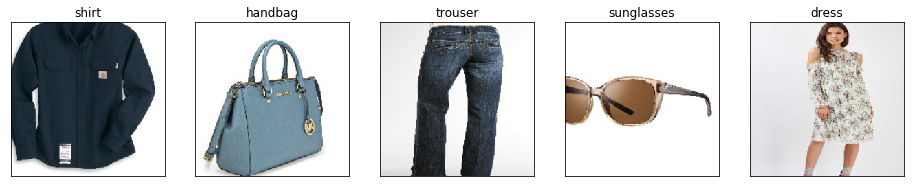

In [27]:
tr_ret_img.show(nimages=5,randomize=True)

In [28]:
# We can take a look at our model this way
model_vgg16.print_summary()

*==================*===============*========*============*=================*======================*
|   Layer (Type)   |  Kernel Size  | Stride | Activation |   Output Size   | Number of Parameters |
*------------------*---------------*--------*------------*-----------------*----------------------*
| data(Input)      |     None      |  None  |    None    |  (224, 224, 3)  |        0 / 0         |
| conv1_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      1728 / 64       |
| conv1_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (224, 224, 64)  |      36864 / 64      |
| pool1(Pool)      |    (2, 2)     |   2    |    Max     | (112, 112, 64)  |        0 / 0         |
| conv2_1(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     73728 / 128      |
| conv2_2(Convo.)  |    (3, 3)     |   1    | Rectifier  | (112, 112, 128) |     147456 / 128     |
| pool2(Pool)      |    (2, 2)     |   2    |    Max     |  (56, 56, 128)  |        0 / 0         |


Now - We can start Training!

In [29]:
model_vgg16.fit(data=tr_ret_img, mini_batch_size=1, max_epochs=3, lr=5E-3)
#model_vgg16.fit(data=tr_ret_img, mini_batch_size=1, max_epochs=3, lr=5E-3, validtable=te_ret_img)

NOTE: Training based on existing weights.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 134281029.
NOTE:  The approximate memory cost is 19513.00 MB.
NOTE:  Loading weights cost       3.46 (s).
NOTE:  Initializing each layer cost       7.45 (s).
NOTE:  The total number of workers is 2.
NOTE:  The total number of threads on each worker is 24.
NOTE:  The total number of minibatch size per thread on each worker is 1.
NOTE:  The maximum number of minibatch size across all workers for the synchronous mode is 48.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      5
NOTE:  Levels for the target variable:
NOTE:  Level      0: shirt     
NOTE:  Level      1: dress     
NOTE:  Level      2: handbag   
NOTE:  Level      3: sunglasses
NOTE:  Level      4: trouser   
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch              nUsed   Learning Rate     Loss    Fit Error      T

NOTE:        6               48   0.005           0.012           0        13.32
NOTE:        7               48   0.005          0.0172           0        13.82
NOTE:        8               48   0.005          0.0019           0        12.97
NOTE:        9               48   0.005          0.0086           0        13.81
NOTE:       10               48   0.005          0.0061           0        12.94
NOTE:       11               48   0.005          0.0076           0        15.31
NOTE:       12               48   0.005          0.1034      0.0417        14.93
NOTE:       13               48   0.005          0.0018           0        14.57
NOTE:       14               48   0.005          0.0053           0        13.92
NOTE:       15               48   0.005           0.037      0.0208        15.67
NOTE:       16               48   0.005          0.0009           0        14.51
NOTE:       17               48   0.005          0.0053           0        13.23
NOTE:       18              

NOTE:       25               48   0.005            0.01           0        13.83
NOTE:       26               48   0.005          591E-7           0        13.97
NOTE:       27               48   0.005          0.0014           0        12.97
NOTE:       28               48   0.005           0.001           0        13.83
NOTE:       29               48   0.005          0.0085           0        15.47
NOTE:       30               48   0.005          0.0005           0        14.02
NOTE:       31               48   0.005          0.0008           0        14.98
NOTE:       32               48   0.005           0.007           0        14.84
NOTE:       33               48   0.005          503E-7           0        18.79
NOTE:       34               48   0.005          265E-7           0        13.31
NOTE:       35               48   0.005          0.0065           0        13.08
NOTE:       36               48   0.005          0.0013           0        12.96
NOTE:       37              

,Descr,Value
0,Model Name,vgg16_notop
1,Model Type,Convolutional Neural Network
2,Number of Layers,22
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,2
8,Number of Weight Parameters,134268608
9,Number of Bias Parameters,12421


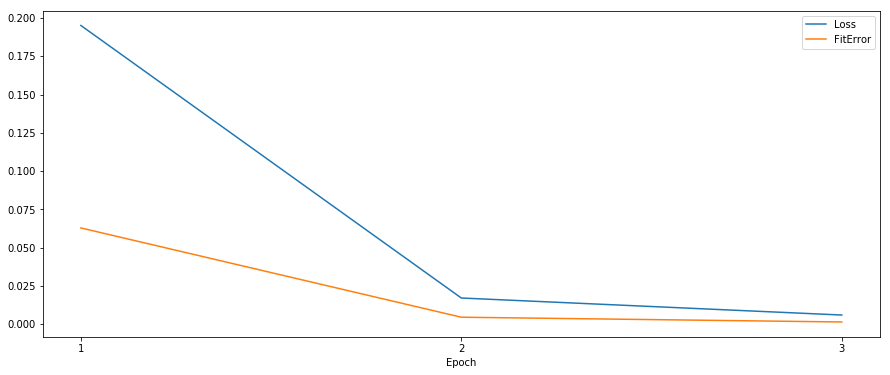

In [30]:
model_vgg16.plot_training_history(fig_size=(15, 6))

In [31]:
model_vgg16.predict(data=te_ret_img)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           242
 1  Number of Observations Used           242
 2  Misclassification Error (%)      0.413223
 3                   Loss Error      0.017359

[OutputCasTables]

                 casLib              Name  Rows  Columns  \
 0  CASUSER(viyademo01)  Valid_Res_AIa9Ql   242       11   
 
                                             casTable  
 0  CASTable('Valid_Res_AIa9Ql', caslib='CASUSER(v...  

+ Elapsed: 21.8s, user: 403s, sys: 18.2s, mem: 3.67e+04mb

In [32]:
model_vgg16.valid_conf_mat

,_label_,Col1,Col2,Col3,Col4,Col5
0,dress,48.0,0.0,1.0,0.0,0.0
1,handbag,0.0,49.0,0.0,0.0,0.0
2,shirt,0.0,0.0,47.0,0.0,0.0
3,sunglasses,0.0,0.0,0.0,49.0,0.0
4,trouser,0.0,0.0,0.0,0.0,48.0


#### An example of a correctly classified image

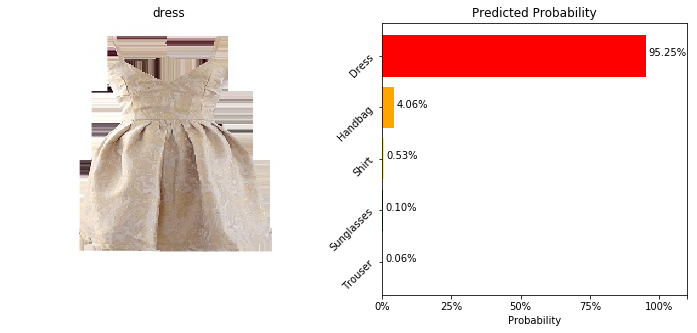

In [33]:
model_vgg16.plot_predict_res(type='C',image_id=2)

#### Misclassified Image

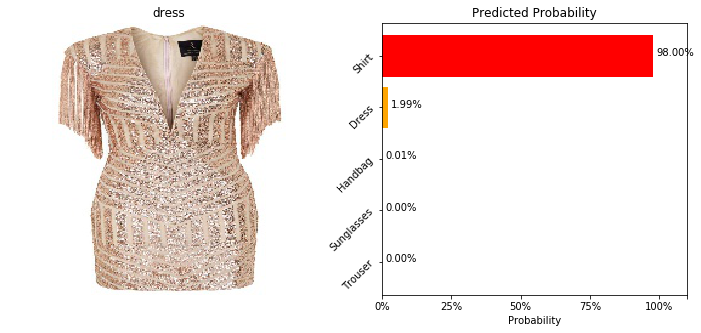

In [34]:
model_vgg16.plot_predict_res(type='M')

#### Lets get some intuition around whats being learned

NOTE: The number of images in the table is too large, only 5 randomly selected images are used in analysis.
NOTE: Table IMAGEDATA_QGLDV9 contains compressed images.


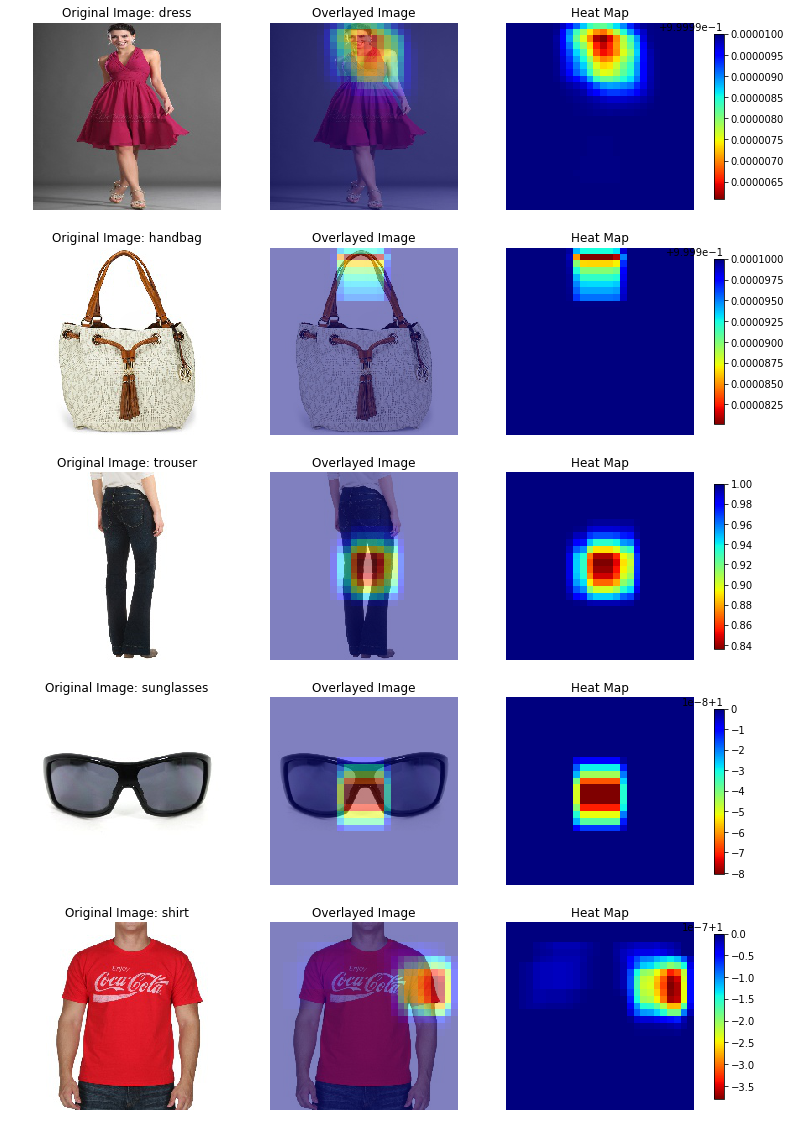

,_filename_0,_image_,_label_,heat_map
0,00000223.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,dress,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,00000033.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,handbag,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,00000207.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,trouser,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,00000051.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,sunglasses,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,00000068.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,shirt,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [35]:
model_vgg16.heat_map_analysis(data=te_ret_img, mask_width=56, mask_height=56, step_size=8)

#### Save the astore for scoring in ESP

In [29]:
model_vgg16.deploy(path='/tmp/retail', output_format='astore')

NOTE: Model astore file saved successfully.


#### For more permanent model persistence - across sessions, lets take another route

In [36]:
conn.loadactionset('aStore')

NOTE: Added action set 'aStore'.


[actionset]

 'aStore'

+ Elapsed: 0.0154s, user: 0.00663s, sys: 0.00497s, mem: 0.607mb

In [38]:
conn.deeplearn.dlexportmodel(modeltable='VGG16_notop',initweights='VGG16_NOTOP_WEIGHTS', casout={'caslib':'Public',
                                                                                            'name':'vgg_16_notop_sirretail',
                                                                                            'promote':True})

NOTE: Wrote 537137350 bytes to the savestate file vgg_16_notop_sirretail.


,casLib,Name
0,Public,vgg_16_notop_sirretail


In [42]:
#change into the caslib - by setting it active
conn.setsessopt(caslib='Public')
conn.tableinfo()

NOTE: 'Public' is now the active caslib.


,Name,Label,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,...,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,VGG_16_NOTOP_SIRRETAIL,,1,2,0,utf-8,04Sep2018:00:20:44,04Sep2018:00:20:44,04Sep2018:00:20:44,UTF8,...,1.851640e+09,1.851640e+09,0,1,0,,,0,viyademo01,
1,LG_CUSTOMER,,56557,17,0,utf-8,25Apr2018:23:33:05,25Apr2018:23:33:06,19Jun2018:16:46:02,UTF8,...,1.840318e+09,1.845046e+09,1,0,0,LG_CUSTOMER.sashdat,Public,0,viyademo01,
2,LG_ORIG_ABT,,56557,104,0,utf-8,25Apr2018:23:33:07,25Apr2018:23:33:15,19Jun2018:16:45:48,UTF8,...,1.840318e+09,1.845046e+09,1,0,0,lg_orig_abt.sas7bdat,Public,0,viyademo01,
3,LG_FINAL_ABT,,56557,121,0,utf-8,25Apr2018:23:36:03,25Apr2018:23:36:10,19Jun2018:17:03:04,UTF8,...,1.840319e+09,1.845047e+09,1,0,0,LG_FINAL_ABT.sashdat,Public,0,viyademo01,
4,CHURN_STZD,churn,3333,23,0,utf-8,26Apr2018:03:18:55,26Apr2018:03:18:55,13Jun2018:01:30:10,UTF8,...,1.840332e+09,1.844473e+09,1,0,0,CHURN_STZD.sashdat,Public,0,viyademo01,
5,PVA97NK,,9686,28,0,utf-8,30Apr2018:01:01:54,30Apr2018:01:01:54,13Jun2018:02:44:19,UTF8,...,1.840669e+09,1.844477e+09,1,0,0,PVA97NK.sashdat,Public,0,viyademo01,
6,CHURN,churn,3333,23,0,utf-8,03May2018:17:26:54,03May2018:17:26:54,12Jun2018:19:39:24,UTF8,...,1.840988e+09,1.844452e+09,1,0,0,CHURN.sashdat,Public,0,viyademo01,
7,OUTFOR,,2912,11,0,utf-8,23May2018:22:25:10,23May2018:22:25:11,09Jul2018:21:14:44,UTF8,...,1.842734e+09,1.846790e+09,1,0,0,,,0,viyademo01,
8,CAS_LENET_SCORE,,1,2,0,utf-8,31May2018:05:59:03,31May2018:05:59:03,04Jul2018:20:39:56,UTF8,...,1.843366e+09,1.846356e+09,1,1,0,,,0,viyademo01,
9,REC,,100003,4,0,utf-8,13Jun2018:02:45:26,13Jun2018:02:45:26,14Jun2018:18:42:46,UTF8,...,1.844477e+09,1.844621e+09,1,0,0,REC.sashdat,Public,0,viyademo01,


In [44]:
m=conn.describe(
     rstore='VGG_16_NOTOP_SIRRETAIL',
     epcode=True
    )
m

[Key]

 Store Key
 
                                         Key
 0  50A818A8D53B95DA2F815D7A2086F7098C5F0260

[Description]

 Run Information
 
          Attribute               Value
 0  Analytic Engine           deeplearn
 1     Time Created  03Sep2018:20:20:38

[InputVariables]

 Input Variables
 
       Name   Length   Role      Type RawType FormatName
 0  _image_  29541.0  Input  Interval    Char           

[OutputVariables]

 Output Variables
 
                   Name  Length  Type                          Label
 0       P__label_shirt     8.0   Num       Predicted: _label_=shirt
 1       P__label_dress     8.0   Num       Predicted: _label_=dress
 2     P__label_handbag     8.0   Num     Predicted: _label_=handbag
 3  P__label_sunglasses     8.0   Num  Predicted: _label_=sunglasses
 4     P__label_trouser     8.0   Num     Predicted: _label_=trouser
 5            I__label_    10.0  Char                  Into: _label_

[epcode]

 ' data sasep.out;\n\t dcl package score sc();\n\t dcl nchar(29541) "_image_";\n\t dcl double "P__label_shirt" having label n\'Predicted: _label_=shirt\';\n\t dcl double "P__label_dress" having label n\'Predicted: _label_=dress\';\n\t dcl double "P__label_handbag" having label n\'Predicted: _label_=handbag\';\n\t dcl double "P__label_sunglasses" having label n\'Predicted: _label_=sunglasses\';\n\t dcl double "P__label_trouser" having label n\'Predicted: _label_=trouser\';\n\t dcl nchar(10) "I__label_" having label n\'Into: _label_\';\n\t Keep \n\t\t "P__label_shirt" \n\t\t "P__label_dress" \n\t\t "P__label_handbag" \n\t\t "P__label_sunglasses" \n\t\t "P__label_trouser" \n\t\t "I__label_" \n\t\t;\n\t varlist allvars[_all_];\n\t method init();\n\t\t sc.setvars(allvars);\n\t\t sc.setKey(n\'50A818A8D53B95DA2F815D7A2086F7098C5F0260\');\n\t end;\n\t method preScoreRecord();\n\t end;\n\t method postScoreRecord();\n\t end;\n\t method term();\n\t end;\n\t method run();\n\t\t set sasep.in;\n\t\t preScoreRecord();\n\t\t sc.scoreRecord();\n\t\t postScoreRecord();\n\t end;\n enddata;\n'

+ Elapsed: 24.5s, user: 58s, sys: 4.56s, mem: 4.43e+03mb

In [45]:
conn.close()